# MIPD of warfarin

In [14]:
import os

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import myokit
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

from model import define_wajima_model

## Visualise demographics of trial cohort

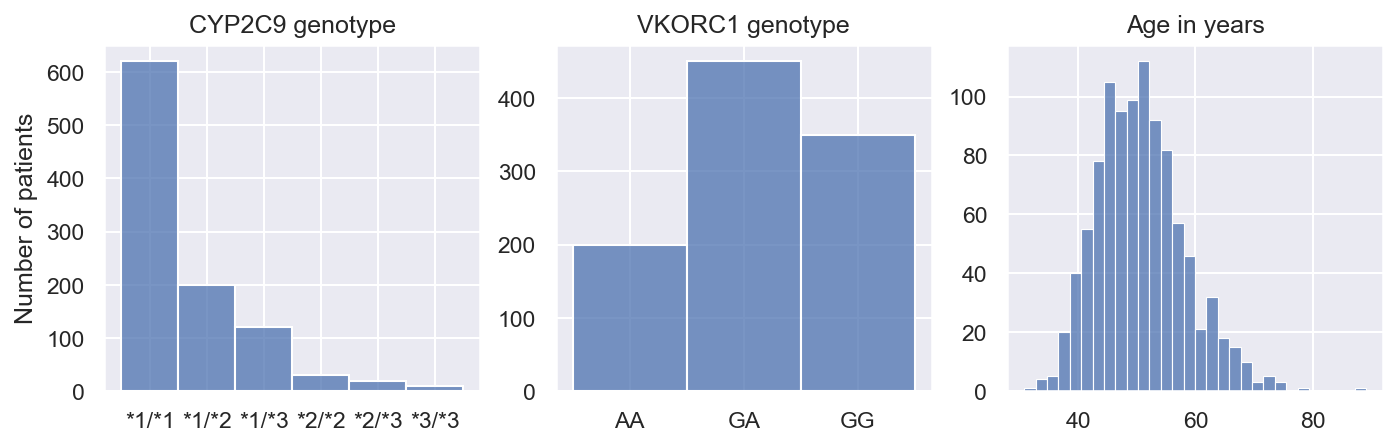

In [11]:
# Import data
directory = os.path.dirname(os.getcwd())
df_demo = pd.read_csv(directory + '/data/mipd_trial_cohort.csv')

# Reshape data
ids = df_demo.ID.dropna().unique()
cyp = []
vkorc = []
age = np.empty(len(ids))
cyp_decoder = {
    0: '*1/*1', 1: '*1/*2', 2: '*1/*3', 3: '*2/*2', 4: '*2/*3', 5: '*3/*3'}
vkorc_decoder = {0: 'GG', 1: 'GA', 2: 'AA'}
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    cyp.append(cyp_decoder[int(temp['CYP2C9'].values)])
    vkorc.append(vkorc_decoder[int(temp['VKORC1'].values)])
    age[idx] = temp['Age'].values
cyp.sort()
vkorc.sort()

# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot CYP2C9 distribution
sns.histplot(cyp, ax=axes[0])
sns.histplot(vkorc, ax=axes[1])
sns.histplot(age, ax=axes[2])

# Label axes
titles = ['CYP2C9 genotype', 'VKORC1 genotype', 'Age in years']
ylabels = ['Number of patients', '', '']
for ida, ax in enumerate(axes):
    ax.set_title(titles[ida])
    ax.set_ylabel(ylabels[ida])

plt.show()

## Evaluate optimal dosing strategy

This establishes a "best case scenario" where our model captures the
dose response perfectly.

Simulate INR response for optimal dosing strategy

In [30]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Load dosing strategy
directory = os.getcwd()
df_doses = pd.read_csv(directory + '/mipd_trial_optimal_dosing_regimens.csv')

# Convert dosing strategy to dosing regimens
days = 19
cal_time = 100 * 24
duration = 0.01
dosing_regimens = {}
for _id in df_doses.ID.dropna().unique():
    temp = df_doses[df_doses.ID == _id]
    doses = temp[['Dose %d in mg' % (idx+1) for idx in range(days)]].values[0]
    dose_rates = np.array(doses) / duration
    regimen = myokit.Protocol()
    for day, dr in enumerate(dose_rates):
        regimen.add(myokit.ProtocolEvent(
            level=dr,
            start=cal_time+day*24,
            duration=duration))
    dosing_regimens[int(_id)] = regimen

# Simulate INR response to treatment
times = cal_time + np.arange(days) * 24
inrs = np.empty(shape=(len(df_doses.ID.dropna().unique()), len(times)))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    # Set dosing regimen
    model.set_dosing_regimen(dosing_regimens[int(_id)])

    # Simulate treatment response
    mask = ids == _id
    inrs[idx] = model.simulate(parameters=parameters[mask][0], times=times)

Visualise treatment response

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


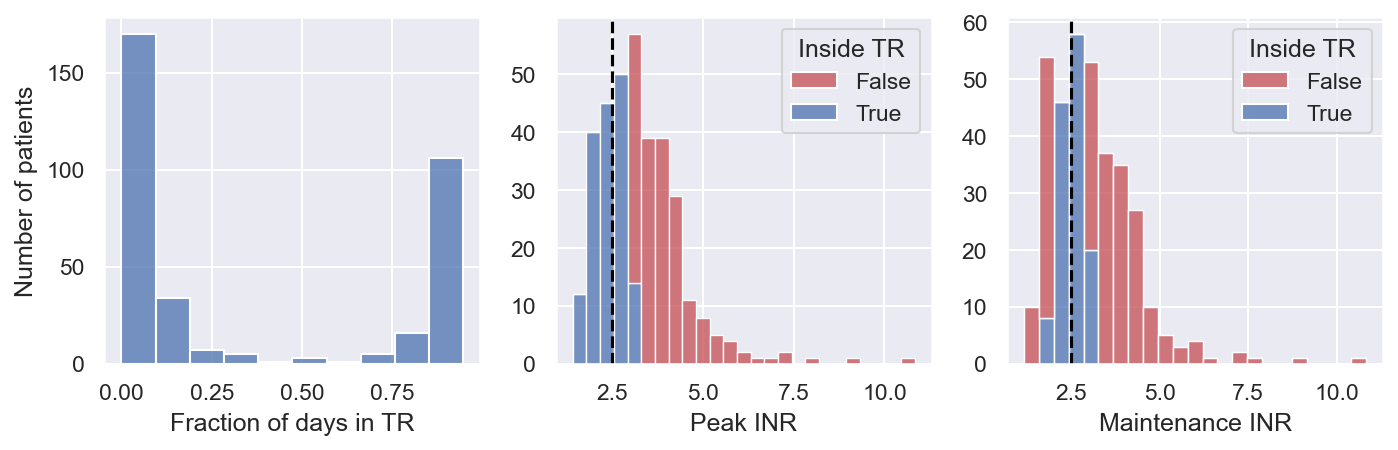

In [81]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs >= 2) & (inrs <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(ttr, ax=axes[0])

# Plot distribution of peak INR
max_inrs = np.max(inrs, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack',
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# Plot maintenance INR distirbution
final_inrs = inrs[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack',
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')


# Label axes
axes[0].set_xlabel('Fraction of days in TR')
axes[0].set_ylabel('Number of patients')
axes[1].set_xlabel('Peak INR')
axes[1].set_ylabel('')
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('')

plt.show()

## Evaluate linear regression model

Simulate INR response for predicted dosing regimens

In [120]:
# Define model
model, _ = define_wajima_model(patient=True, inr_test=True)

# Get patient parameters
ids = df_demo.ID.dropna().unique()
parameters = np.empty(shape=(len(ids), model.n_parameters()))
for idx, _id in enumerate(ids):
    temp = df_demo[df_demo.ID == _id]
    parameters[idx] = temp[model.parameters()].values[0]

# Load dosing strategy
directory = os.path.dirname(os.getcwd())
df_doses = pd.read_csv(
    directory + '/3_linear_regression_model'
    '/mipd_trial_predicted_dosing_regimens.csv')

# Convert dosing strategy to dosing regimens
# The induction doses are fixed to 10, 5 on days 1 and 2
days = 19
cal_time = 100 * 24
duration = 0.01
dosing_regimens = {}
for _id in df_doses.ID.dropna().unique():
    temp = df_doses[df_doses.ID == _id]
    doses = [10, 5] + [temp['Maintenance dose'].values[0]] * (days - 2)
    dose_rates = np.array(doses) / duration
    regimen = myokit.Protocol()
    for day, dr in enumerate(dose_rates):
        regimen.add(myokit.ProtocolEvent(
            level=dr,
            start=cal_time+day*24,
            duration=duration))
    dosing_regimens[int(_id)] = regimen

# Simulate INR response to treatment
times = cal_time + np.arange(days) * 24
inrs = np.empty(shape=(len(df_doses.ID.dropna().unique()), len(times)))
for idx, _id in enumerate(df_doses.ID.dropna().unique()):
    # Set dosing regimen
    model.set_dosing_regimen(dosing_regimens[int(_id)])

    # Simulate treatment response
    mask = ids == _id
    try:
        inrs[idx] = model.simulate(parameters=parameters[mask][0], times=times)
    except myokit.SimulationError:
        inrs[idx] = np.nan

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/myokit/_sim/cvodessim.py:652: RuntimeWarning: CVODES: Internal t = 2520.61 and h = 2.4272e-14 are such that t + h = t on the next step. The solver will continue anyway.
  t = self._sim.sim_step()
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/myokit/_sim/cvodessim.py:652: RuntimeWarning: CVODES: Internal t = 2520.61 and h = 1.517e-14 are such that t + h = t on the next step. The solver will continue anyway.
  t = self._sim.sim_step()
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/myokit/_sim/cvodessim.py:652: RuntimeWarning: CVODES: Internal t = 2520.61 and h = 3.7925e-15 are such that t + h = t on the next step. The solver will continue anyway.
  t = self._sim.sim_step()
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/myokit/_sim/cvodessim.py:652: RuntimeWarning: CVODES: Internal t = 2520.61 and h = 9.48126e-16 are su

NOTE: Above step size warnings occur because the dosing regimen drives the QSP
model into numerical instability. If this results in a myokit.SimulationError
we set the predicted INR to NaN and exclude the individuals from the results.
A simulation error likely means that INR is far away from the therapeutic
window.

In [122]:
print('Number of patients with simulation error: %d of 1000' % np.sum(np.isnan(inrs[:, 0])))

Number of patients with simulation error: 4 of 1000


Visualise treatment response

/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/david/Workspace/sabs-r3/mipd-warfarin/venv/lib/python3.9/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


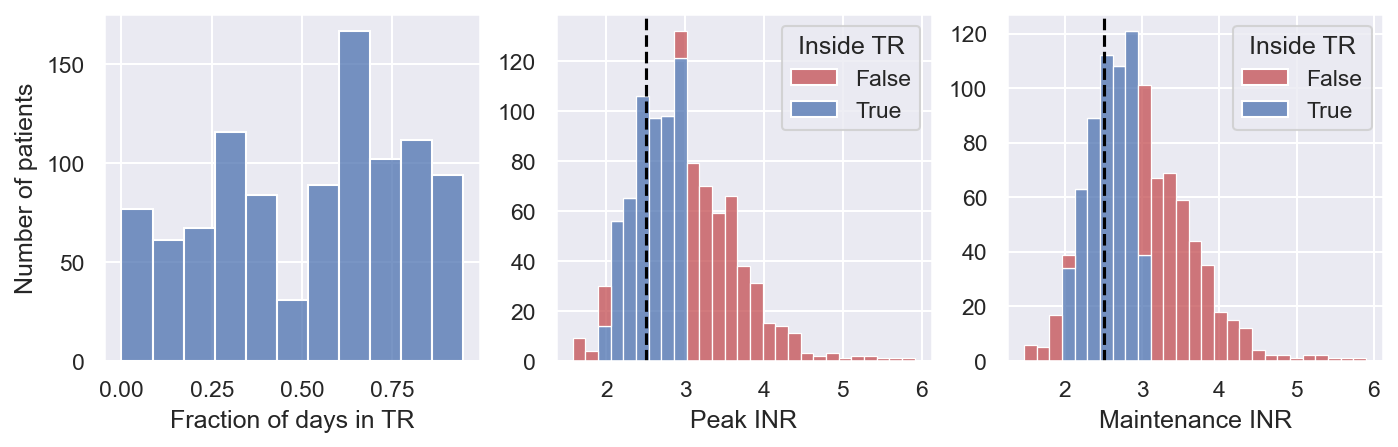

In [121]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, hspace=2.5)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
in_tr = (inrs >= 2) & (inrs <= 3)
ttr = np.mean(in_tr, axis=1)
sns.histplot(ttr, ax=axes[0])

# Plot distribution of peak INR
max_inrs = np.max(inrs, axis=1)
df = pd.DataFrame({
    'INR': max_inrs, 'Inside TR': (max_inrs>=2) & (max_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[1], multiple='stack',
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[1].axvline(x=2.5, color='black', linestyle='dashed')

# # Plot maintenance INR distirbution
final_inrs = inrs[:, -1]
df = pd.DataFrame({
    'INR': final_inrs, 'Inside TR': (final_inrs>=2) & (final_inrs<=3)})
sns.histplot(
    df, x='INR', hue='Inside TR', ax=axes[2], multiple='stack',
    palette=[sns.color_palette()[3], sns.color_palette()[0]])
axes[2].axvline(x=2.5, color='black', linestyle='dashed')


# Label axes
axes[0].set_xlabel('Fraction of days in TR')
axes[0].set_ylabel('Number of patients')
axes[1].set_xlabel('Peak INR')
axes[1].set_ylabel('')
axes[2].set_xlabel('Maintenance INR')
axes[2].set_ylabel('')

plt.show()